In [6]:
## Importing dependencies-------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import random
import math
import warnings
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt
import seaborn as sns

PATH = '/Users/dhamada/honeybee-foraging/' ## New user? Change me!
os.chdir(PATH)

#DELETED FREQ PARAMETER FROM DEFINITIONS_2018
from bees_lifetimetracking_2018data import datafunctions
from bees_lifetimetracking_2018data import definitions_2018 as bd
from bees_lifetimetracking_2018data import displayfunctions as bp
from bees_lifetimetracking_2018data import definitions2024 as bn

datafunctions.init(bd) 
bp.init(bd)
warnings.filterwarnings("ignore")

# Establishing date range and basic dataset information----------------------------------------------------
year = 2018
startday = pd.Timestamp(year,7,16)  # actual, for 2018:   16 July  (cameras turned on)
endday = pd.Timestamp(year,10,9)    # actual, for 2018:   was 10 September, but is now 09 Oct
alldaytimestamps = pd.date_range(start=startday,end=endday,freq='D')
numdays = len(alldaytimestamps)
numbees = 4096  # This is the total number of barcodes, NOT the total number of bees actually tracked
numsubstrates = 10 # 10 actual substrates, and then 0 for undefined
comb_daynums = np.array([ 0,  5, 10, 15, 20, 26, 30, 35, 40, 44, 65, 75, 85]) + 16 - startday.day  # days from start day, assuming start day is in July

pix = bd.xpixels #for methods in definitions2024

def rawLeaveEvents(daynum, beeTraj, hiveEvents):
    dfIntersect = hiveEvents.merge(beeTraj, how='right', on = ['uid','framenum'])
    #exit_dist------------------------------------------------------------------------------------
    dfIntersect = getExitDist(dfIntersect)
    
    result = dfIntersect[((dfIntersect['status']=='leave') | (dfIntersect['status']=='return'))]
    #result = dfIntersect[((dfIntersect['status']=='return'))]
    
    result = result.sort_values(by=['daynum', 'uid', 'framenum'])
    
    result['next status'] = result['status'].shift(-1)
    result['next uid'] = result['uid'].shift(-1)
    result['next framenum'] = result['framenum'].shift(-1)
    
    conditions = [
        ((result['status'] == 'leave') & (result['next status'] == 'return') & (result['next uid'] == result['uid']) & (result['next framenum']- result['framenum'] < 1000)),
        ((result['status'] == 'leave') & (result['next status'] == 'return') & (result['next uid'] == result['uid']) & (result['next framenum']- result['framenum'] >= 1000)),
        (result['status'] == 'return'),
        ((result['status'] == 'leave') & (result['next uid'] != result['uid']))
    ]
    choices = ['short with return', 'long with return', 'return event', 'disappeared']
    result['event type'] = np.select(conditions, choices, default='not sure')
    
    
    #result = dfIntersect[dfIntersect['exit_dist']<=1000] #threshold = 1000
    #result = dfIntersect[dfIntersect['status']=='leave']
    #result = dfIntersect[dfIntersect['event type']=='long with return']
    
    result = bn.numOfDanceFloorVisits(result, beeTraj, 1800)
    
    return result

def loadData(daynum):
    global dfday, day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist, numtimedivs
    ### DID THE BEE LEAVE? ------------------------------------------------------------------
    dataDir = PATH + 'df_day1min_alldays/'
    dfday = pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(dataDir,daynum))
    numtimedivs = len(dfday['timedivision'].unique()) # minutes in a day
    day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday, exitdistthreshold=1000, numtimedivs=numtimedivs)

## Adds column of distances from the exit
def getExitDist(df):
    df['exit_dist'] = datafunctions.getexitdistance(df.x,df.y,df.camera)
    return df

## Creates dataframe based on given day and adds available information.
def getBeeTraj(daynum):
    if daynum >= 50:
        datadir = PATH + 'Data/zenodo/beetrajectories_days_050_to_085/'
    else:
        datadir = PATH + 'Data/zenodo/beetrajectories_days_000_to_049/'
    
    beeTrajectoriesByFrame = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum)) #data per frame in which each bee was seen
    beeTrajectoriesByFrame = getExitDist(beeTrajectoriesByFrame)
    beeTrajectoriesByFrame= bn.crossedDanceFloor(beeTrajectoriesByFrame, pix)
    #beeTrajectoriesByFrame = bn.numOfDanceFloorVisitsRUNNINGTOTAL(beeTrajectoriesByFrame)
    beeTrajectoriesByFrame = beeTrajectoriesByFrame.groupby('uid', group_keys=False).apply(bn.framesSinceLastCross)
    return beeTrajectoriesByFrame

def getHiveEvents(daynum):
    # boolInHiveByIDByTime into dataframe ----------------------------------------------------
    inHive = pd.DataFrame(boolInHiveByIDByTime)
    inHive = inHive.T #transpose so rows = time and cols = uid
                                
    #get hive statuses by taking difference on axis 0 (rows, which represent time)
    hive_statuses_list = np.diff(inHive, axis = 0) # TODO document code
    #print(len(hive_statuses_list[1])) #PRINT CHECK (len 1439, len of each is 1435)
    
    # translate time to framenum (assuming 3 frames per second)-------------------------------
    frames_per_day = 24*60*60*3
    frames_per_timedivision = frames_per_day / numtimedivs
    
    """
    inHive['index'] = range(len(inHive))
    inHive['minsPastMidnight'] = inHive['index']*1 #bin size = 1min (see datafunctions.py), TODO un-hardcode
    
    
    inHive['framenum'] = inHive['index']*frames_per_timedivision
    """
    
    hive_statuses_by_uid = []
    
    #return [i for i in zip(day_uids,hive_statuses_list)]
    
    hive_statuses_list = np.transpose(hive_statuses_list) # First index is beeUID, second is minute
    for uid, hive_statuses in zip(day_uids,hive_statuses_list):
        for hive_status in hive_statuses:
            hive_statuses_by_uid.append([uid,hive_status])
    df_hive_events = pd.DataFrame(hive_statuses_by_uid,columns=['uid','diff'])
    df_hive_events['index'] = range(len(df_hive_events))
    
    #minutes and framenum columns---------------------------------------------------------------
    result = []
    numEntriesPerUid = len(df_hive_events[df_hive_events['uid'] == df_hive_events['uid'].iat[0]])
    for value in df_hive_events['index']:
        result.append(value % numEntriesPerUid)
    df_hive_events['min'] = result
    
    df_hive_events['framenum'] = df_hive_events['min']*frames_per_day/(24*60) #use time_functions_2019.py from git repo to fix!!
    
    df_hive_events = df_hive_events[['index', 'uid', 'diff', 'min', 'framenum']]
    
    #stauses--------------------------------------------------------------------------------------
    conditions = [
        (df_hive_events['diff'] == -1.0),
        (df_hive_events['diff'] == 1.0),
        (df_hive_events['diff'] == 0.0),
    ]
    choices = ['leave', 'return', 'no change']
    df_hive_events['status'] = np.select(conditions, choices, default='not sure')
    
    """
    for plotting purposes, single out rows in beetraj df and surrounding rows to track data.
    
    add function to do exit distance and num dance floor visits for selected rows (new df)
    """
    
    return df_hive_events

#defines frameNew, frameReturn, frameGone, and returns leaveEvents dataFrame
def getLeaveEvents(daynum, beeTraj, hiveEvents):
    rawEvents = pd.DataFrame()
    rawEvents = rawLeaveEvents(daynum, beeTraj, hiveEvents)
    
    filteredEvents = pd.DataFrame()
    filteredEvents, frameNew, frameReturn, frameGone = getPlottingEvent(daynum, df, frame, beeID, framesBefore, framesAfter)
    
    #filteredEvents = rawEvents.drop(columns=['index', 'diff', 'status'])
    return filteredEvents
# Modify to check location before leaving and time gone.

def plotEvent(daynum, frameLeave, frameReturn, beeID, framesBefore, framesAfter, onlyBefore):
    # getting desired rows
    plotPoint = pd.DataFrame()
    plotPoint, minFrame, maxFrame, lastFrame, frameLeave, frameReturn = bn.getPlottingEvent1(daynum, beeTraj, frameLeave, frameReturn, beeID, framesBefore, framesAfter)

    if plotPoint.iloc[0]['framenum'] > minFrame:
        minFrame = plotPoint.iloc[0]['framenum']
        
    # create figure x = framenum, y = y, color gradient = x
    plt.figure(figsize=(10, 6))
    
    #""" EXIT DISTANCE VS FRAMENUM
    plt.scatter(plotPoint['framenum'], plotPoint['exit_dist'], s=10, alpha=0.8, label='Data')

    #labels
    plt.xlabel('Frame Number')
    plt.ylabel('Exit Distance')
    plt.title('Plot of Exit Distance vs. Frame Number')
    #"""

    # green dashed line to indicate where the 'leave' event is
    plt.axvline(x=frameLeave, color='lawngreen', linestyle='-', label='Leave')

    if not onlyBefore:
        #new black line to indicate bee disappearance
        if(lastFrame <= maxFrame):
            plt.axvline(x=lastFrame, color='black', linestyle='-', label='Disappearance')
    
        # red dashed line to indicate where the 'return' is
        plt.axvline(x=frameReturn, color='red', linestyle='-', label='Return')
    else:
        plt.xlim(minFrame, frameLeave + 50)  # show only data before 'leave'
        
    #Add grid and legend, then show plot
    plt.gca().yaxis.grid(True)
    plt.legend(loc = 'lower center')
    plt.show()

FRAMES_PER_SECOND = 3
def framenum_to_datetime(daynum,framenum,frames_per_second=FRAMES_PER_SECOND):
    return bd.alldaytimestamps[daynum] + dt.timedelta(seconds=int(framenum/frames_per_second))

#data should be beeTraj, duration in frames, visits threshold in frames
def NEWleavingEvents(data, exitThreshold, durationReq, dfVisitsThreshold): 
    '''
    data = data.sort_values(by=['daynum', 'uid', 'framenum'])
    data['framenum_diff'] = data.groupby(['daynum', 'uid'])['framenum'].shift(-1) - data['framenum']

    for i in range(1, len(data)):
        data.loc[i, 'status'] = 'no change'
        
        if ((data.loc[i, 'framenum_diff'] >= durationReq) & (data.loc[i, 'exit_dist'] <= exitThreshold)):
            data.loc[i, 'status'] = 'leave'
        if data.loc[i-1, 'status'] == 'leave':
            data.loc[i, 'status'] = 'return'
            
    data = data[data['status'] == 'leave']
    data = bn.numOfDanceFloorVisits(data, beeTraj, dfVisitsThreshold)
    data['datetime'] = data.apply(lambda row: framenum_to_datetime(row['daynum'], row['framenum']), axis=1)
    '''
    data = data.sort_values(by=['daynum', 'uid', 'framenum'])
    data['framenum_diff'] = data.groupby(['daynum', 'uid'])['framenum'].shift(-1) - data['framenum']
    data['status'] = 'no change'
    data.loc[(data['framenum_diff'] >= durationReq) & (data['exit_dist'] <= exitThreshold), 'status'] = 'leave'
    data['status'] = np.where(data['status'].shift(1) == 'leave', 'return', data['status'])
    
    data = data[(data['status'] == 'leave') | (data['status'] == 'return')]
    
    #data = bn.numOfDanceFloorVisits(data, beeTraj, dfVisitsThreshold)
    #data = bn.framesSinceLastCross(data)
    #data['datetime'] = framenum_to_datetime(data['daynum'], data['framenum'])
    data['datetime'] = data.apply(lambda row: framenum_to_datetime(row['daynum'], row['framenum']), axis=1)
    return data

def dayToCSV(daynum = 1, exit_threshold = 1000, min_time_gone = 900, time_threshold_historical_dfvists = 1800):
    # load in day's data
    loadData(daynum)
    beeTraj = getBeeTraj(daynum)
    ages = dfday[['Age', 'Bee unique ID']]

    # identify leaving events
    leavingEvents = NEWleavingEvents(beeTraj, exit_threshold, min_time_gone, time_threshold_historical_dfvists)
    leavingEvents = leavingEvents[leavingEvents['status'] == 'leave']
    leavingEvents = leavingEvents[['datetime', 'framenum', 'uid', 'status']]

    # merge trajectories (x, y) with leaving event info
    allEvents = pd.merge(beeTraj, leavingEvents, how='left', on = ['uid', 'framenum'], indicator=True)
    allEvents['status'] = allEvents['_merge'].map({'both': 'leave','left_only': 'no change'})

    # take every third frame (now 1 frame/second) but keep all leaving events
    fewerFrames = allEvents.iloc[::3]
    leaveOnly = allEvents[allEvents['status'] == 'leave']
    allEventsFewer = pd.concat([fewerFrames, leaveOnly]).drop_duplicates()
    allEventsFewer = allEventsFewer.reset_index(drop=True)
    allEventsFewer = allEventsFewer.drop(columns=['_merge', 'cross_df', 'theta'])

    # datetime added
    allEventsFewer['datetime'] = allEventsFewer.apply(lambda row: framenum_to_datetime(row['daynum'], row['framenum']), axis=1)

    # tidying
    allEventsFewer.sort_values(by=['daynum', 'uid', 'framenum'])

    # Type matching for merge
    ages['Bee unique ID'] = ages['Bee unique ID'].apply(lambda x: str(int(float(x))) if isinstance(x, (int, float)) else str(x))
    allEventsFewer['uid'] = allEventsFewer['uid'].astype(str)
    allEventsFewer['uid'] = allEventsFewer['uid'].astype(int)
    ages['Bee unique ID'] = ages['Bee unique ID'].astype(int)

    # Whittle down dfs
    allEventsMerge = allEventsFewer[['daynum', 'uid', 'framenum', 'datetime', 'frames_since_df_visit', 'status']]
    agesMerge = ages.drop_duplicates()

    # Merge
    result = allEventsFewer.merge(agesMerge, left_on='uid', right_on='Bee unique ID', how='left')
    result['mins_since_df_visit'] = np.where(result['frames_since_df_visit'] >= 0, result['frames_since_df_visit'] / 3, result['frames_since_df_visit'])
    result['mins_since_df_visit']=result['mins_since_df_visit'].astype(int)
    result = result.drop(columns=['Bee unique ID'])

    # Splitting datetime
    result['datetime'] = pd.to_datetime(result['datetime'])
    
    result['YYYYMMDD'] = result['datetime'].dt.strftime('%Y%m%d').astype(int)
    result['HHMMSS'] = result['datetime'].dt.strftime('%H%M%S').astype(int)
    result['Second (Daily Cycle)'] = result['datetime'].dt.hour*3600 + result['datetime'].dt.minute*60 + result['datetime'].dt.second
    result['Day (Seasonal Cycle)'] = result['daynum']

    # DF ready for analysis!
    result = result.sort_values(by=['uid', 'datetime'])
    result = result[['uid', 'Age', 'datetime', 'Day (Seasonal Cycle)', 'YYYYMMDD', 'Second (Daily Cycle)', 'HHMMSS', 'mins_since_df_visit', 'status']]
    result = result.drop_duplicates()
    
    result.to_csv(f'day{daynum}.csv')
    return result

## Download Day Data as CSVs

In [ ]:
for day in range(0, 49):
    dayToCSV(daynum = day, exit_threshold = 1000, min_time_gone = 900, time_threshold_historical_dfvists = 1800)

In [26]:
dayToCSV(daynum = 0, exit_threshold = 1000, min_time_gone = 900, time_threshold_historical_dfvists = 1800)

,uid,Age,datetime,Day (Seasonal Cycle),YYYYMMDD,Second (Daily Cycle),HHMMSS,mins_since_df_visit,status
73088,402,20.0,2018-07-16 19:05:02,0,20180716,68702,190502,-1,no change
73089,402,20.0,2018-07-16 19:05:04,0,20180716,68704,190504,-1,no change
73090,402,20.0,2018-07-16 19:05:09,0,20180716,68709,190509,-1,no change
73091,402,20.0,2018-07-16 19:05:11,0,20180716,68711,190511,-1,no change
73092,402,20.0,2018-07-16 19:05:13,0,20180716,68713,190513,-1,no change
...,...,...,...,...,...,...,...,...,...
362141,1600,0.0,2018-07-16 23:36:20,0,20180716,84980,233620,754,no change
362142,1600,0.0,2018-07-16 23:36:21,0,20180716,84981,233621,755,no change
362143,1600,0.0,2018-07-16 23:36:22,0,20180716,84982,233622,756,no change
362144,1600,0.0,2018-07-16 23:36:25,0,20180716,84985,233625,757,no change


## View a Day's Leaving Events and Plot Exit Distance vs. Time

In [7]:
#STEP 1: Enter day number, minimum dist from exit in px, minimum time gone in frames, num of frames before to count dance floor visits
daynum = 1
exit_threshold = 1000 # in pixels
min_time_gone = 900 # 900 frames = 5 mins
time_threshold_historical_dfvists = 1800 # in frames

#loading...--------------------
loadData(daynum)
beeTraj = getBeeTraj(daynum)

leavingEvents = NEWleavingEvents(beeTraj, 1000, 900, 1800)
#------------------------------

In [8]:
#Prints your options of leaving events!
leavingEvents[['datetime', 'framenum', 'uid', 'framenum_diff', 'status']]

,datetime,framenum,uid,framenum_diff,status
1259393,2018-07-17 06:54:39,74637,677,9859.0,leave
1419488,2018-07-17 07:49:25,84496,677,1.0,return
3208906,2018-07-17 17:26:37,188392,677,2027.0,leave
3208907,2018-07-17 17:37:53,190419,677,1.0,return
2891143,2018-07-17 15:39:12,169057,781,9166.0,leave
3028149,2018-07-17 16:30:07,178223,781,3.0,return
214522,2018-07-17 01:19:58,14396,850,13471.0,leave
471988,2018-07-17 02:34:49,27867,850,1.0,return
3226235,2018-07-17 17:00:15,183647,886,8270.0,leave
3226236,2018-07-17 17:46:12,191917,886,1.0,return


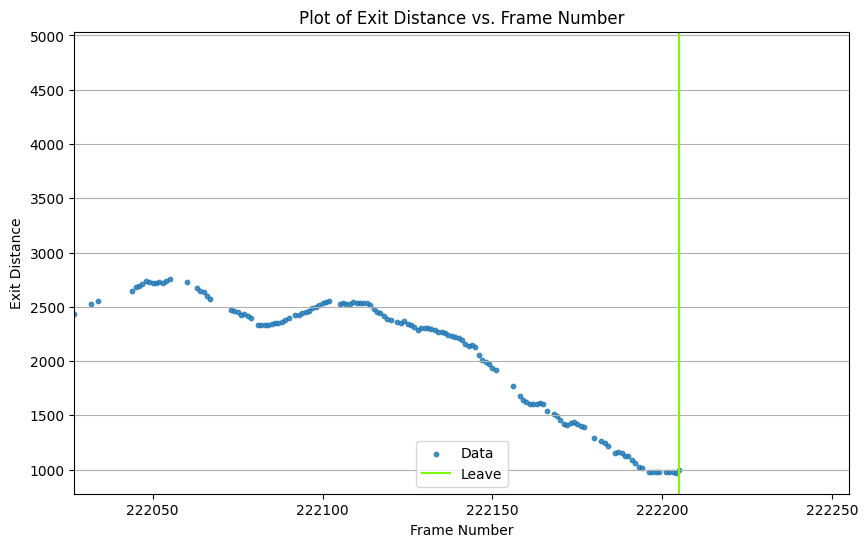

In [9]:
#STEP 2: Enter a framenumber, bee ID, number of frames before (to be plotted), and number of frames after!
frameLeave = 222205.0	
frameReturn = 245719	
beeID = 1538

framesBefore = 1800
framesAfter = 180
onlyBefore = True

#loading...----------------------
plotPoint = plotEvent(daynum, frameLeave, frameReturn, beeID, framesBefore, framesAfter, onlyBefore)
plotPoint
#--------------------------------